# Parameter Estimation for Double Mutants

(c) 2017 the authors. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained herein is licensed under an [MIT license](https://opensource.org/licenses/MIT).  

In [12]:
# For operating system interaction
import os
import glob
import datetime
import sys

# For loading .pkl files.
import pickle

# For scientific computing
import numpy as np
import pandas as pd
import scipy.special

# Library to perform MCMC sampling
import emcee

# Import custom utilities
import mwc_induction_utils as mwc

# Useful plotting libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import corner
mwc.set_plotting_style()

# Magic function to make matplotlib inline; other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline (only use with static plots (non-Bokeh))
%config InlineBackend.figure_format = 'svg'

# Generate a variable with the day that the script is run
today = str(datetime.datetime.today().strftime('%Y%m%d'))

# Defining the problem



Now let's define the function to compute the likelihood, the prior and the posterior probability

In [13]:
# Load all of the 2018 flow data.
flow_files = glob.glob('../../../processing/2018*flow*/output/*fold_change.csv')
dfs = [pd.read_csv(f, comment='#') for f in flow_files]
flow_data = pd.concat(dfs, axis=0)
flow_data = flow_data[(flow_data['fold_change'] >= -0.2) & (flow_data['fold_change'] <= 1.3)]
flow_data = flow_data[(flow_data.mutant != 'Q21A') & \
                     (flow_data.mutant != 'Q21M') & \
                     (flow_data.mutant != 'Y20I') & \
                     (flow_data.mutant != 'F164T') & \
                     (flow_data.mutant != 'Q294R') & \
                     (flow_data.mutant != 'Q294V')]

df = flow_data

# Now we remove the autofluorescence and delta values
df = df[(df.mutant != 'auto') & (df.mutant != 'delta') & (df.operator == 'O2')]

# Restart index
df = df.reset_index()

df.head()

,index,IPTGuM,Unnamed: 0,date,fold_change,mean_FITC_H,mutant,operator,repressors,strain,username
0,2,0.0,2,20180409,-0.004128,5209.473763,wt,O2,260.0,R260,nbellive
1,7,0.1,7,20180409,0.012561,5187.629503,wt,O2,260.0,R260,nbellive
2,12,5.0,12,20180409,0.025843,5390.200563,wt,O2,260.0,R260,nbellive
3,17,10.0,17,20180409,0.039235,5642.453780,wt,O2,260.0,R260,nbellive
4,22,25.0,22,20180409,0.100567,6613.374107,wt,O2,260.0,R260,nbellive


In [35]:
def log_likelihood(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-likelihood
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log likelihood probability
    '''
    # unpack parameters
    ea = param[0:len(unique_var[1])]
    ei = param[len(unique_var[1]):(param_idx[0]-1)]
    sigma = param[param_idx[0]-1] # MWC parameters
    eps_r = param[param_idx[0]:param_idx[1]] # Represor energies
   
    # Initialize the log_likelihood
    log_like = 0
    # loop through the parameters to fit in order to compute the
    # theoretical fold change using the right parameters for each strain
    for i, r in enumerate(unique_var[0]):
        for j, eps in enumerate(unique_var[1]):
            data_block = data[(data[:, 2]==r) & (data[:, 3]==eps), :]
            # compute the theoretical fold-change
            fc_theory = mwc.fold_change_log(data_block[:, 1],
                                            ea[j], ei[j], epsilon,
                                            r, eps_r[j])
            # compute the log likelihood for this block of data
            log_like -=  np.sum((fc_theory - data_block[:, 0])**2) / 2 / sigma**2
            
    return log_like

def log_prior(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log-prior probability
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    log prior probability
    '''
    # unpack parameters
    ea = param[0:len(unique_var[1])]
    ei = param[len(unique_var[1]):(param_idx[0]-1)]
    sigma = param[param_idx[0]-1] # MWC parameters
    eps_r = param[param_idx[0]:param_idx[1]] # Represor energies
    
    # Initialize the log_prior
    log_prior = 0
    # loop through the parameters to to fit in order to compute the appropiate
    # log prior
    for i, r in enumerate(unique_var[0]):
        for j, eps in enumerate(unique_var[1]):

            # add in prior for ea and ei
            if np.any([eps=='wt']):
                log_prior -= np.sum((ea[j] + 4.935)**2 / \
                             2 / 0.06**2)
                log_prior -= np.sum((ei[j] - 0.635)**2 / \
                             2 / 0.06**2)

            # add in prior for wild-type eps
            if np.any([eps=='wt']):
                log_prior -= np.sum((eps_r[j] + 13.9)**2 / \
                             2 / 0.2**2)
    # add in prior for wild-type eps
    if np.any([eps_r >=-5]) or np.any([eps_r <=-20]):
        return -np.inf
                
    # check the bounds on the parameterreps
    if (sigma <= 0):
        return -np.inf
    
    if np.any(ea <= -15) or np.any(ea >= 15) or np.any(ei <= -15) or np.any(ei >= 15):
        return -np.inf
    
    return log_prior

def log_post(param, param_idx, unique_var, data, epsilon=4.5):
    '''
    Computes the log posterior probability.
    Parameters
    ----------
    param : array-like
        Array with the value of all the parameters/dismensions on which the
        MCMC walkers should walk. The array follows this order:
        ea, ei, sigma : first 3 columns.
        repressor copy number : next columns.
        binding energies : final columns.
        The exact position of each of these parameters depends on the number
        of unique repressors and energies as indicated by param_idx.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    unique_var : : list.
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change_A
        data[:, 1] : IPTG_uM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
        data[:, 5] : delta_energy
    epsilon : float.
        Energetic difference between the active and inactive state.
    Returns
    -------
    The log posterior probability
    '''
    # unpack parameters
    ea = param[0:len(unique_var[1])]
    ei = param[len(unique_var[1]):(param_idx[0]-1)]
    sigma = param[param_idx[0]-1] # MWC parameters
    eps_r = param[param_idx[0]:param_idx[1]] # Represor energies
    
    lnp = log_prior(param, param_idx, unique_var, data, epsilon)
    # Check before computing the likelihood if one of the boundaries set by
    # the prior was not satisfied. If that is the case don't waste time
    # computing the likelihood and return -inf
    if lnp == -np.inf:
        return lnp
    
    return -(len(data) + 1) * np.log(sigma)\
            + log_likelihood(param, param_idx, unique_var, data, epsilon)\
            + lnp

In [36]:
def init_walkers_all(df, n_walkers, unique_var, param_idx):
    '''
    Initialize walkers according to however many dimensions will be explored
    by the MCMC
    Parameters
    ----------
    df : pandas DataFrame
        Data frame containing the data that will be used for fitting the
        parameters
    n_walkers : int
        Number of walkers for the MCMC.
    unique_var : : list
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 3 positions of the param argument for the MCMC we find
        epsilon_A, epsilon_I and sigma the error associated with the Gaussian
        likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    n_dim : int
        Number of dimensions that the MCMC walkers will walk on.
        
    Returns
    -------
    [p0, ndim] : list
        The maximum a-priori value from optimization and the number of parameters
        used for the MCMC execution. 
    '''
    #Define the parameters for emcee
    mut_unique = np.sort(df.mutant.unique())
    n_mut = len(mut_unique)
    
    n_dim = 1 + 2*n_mut + n_mut
    
#     # Perform a non-linear regression
#     map_param =  mwc.non_lin_reg_mwc(df, p0=[1, 7], diss_const=False)
#     mean = [map_param[0], map_param[2]]
#     cov = np.array([[map_param[1], 0], [0, map_param[3]]])
    
    # Initialize walkers
    p0 = np.empty((n_walkers, n_dim))
    for j, eps in enumerate(mut_unique):
        p0[:,j] = np.random.normal(-4.935, 1, n_walkers) # ea
        p0[:,j + len(unique_var[1])] = np.random.normal(0.635, 1, n_walkers) # ei
        
    p0[:,param_idx[0]-1] = np.random.uniform(1E-5, 0.2, n_walkers) # sigma
    
    # loop through the repressors

    for j, eps in enumerate(mut_unique):
#         p0[:, param_idx[1]+j] = np.random.normal(eps, sigma_eps, n_walkers)
        p0[:, param_idx[0]+j] = np.random.normal(-13.6, 0.1, n_walkers)
    
    return p0, n_dim



In [37]:
def mcmc_pre_process_all(df):
    """
    Pre-process the tidy DataFrame to prepare it for the MCMC. This is done
    separately from the log-posterior calculation to speed up the process
    avoiding parsing the DataFrame every evaluation of the posterior.
    Parameteres
    -----------
    df : pandas DataFrame.
        A tidy pandas DataFrame as standardized in the project that contains
        at least the following columns:
        fold_change_A : the experimental fold-change from channel A in the
        flow cytometer.
    IPTG_uM : 1d-array
        Concentrations of the inducer in micromolar. 
    repressors : int
        The mean repressor copy number in copies per cell. 
    delta_repressors : float
        The experimental standard deviation on the mean repressor copy number
    binding_energy : float
        The mean repressor binding energy
    delta_energy : float 
        The experimental standard deviation on the binding energy

    Returns
    -------
    [rep_unique, eps_unique] : list
        A list whose first element is the list of the unique mean repressor
        copy number found in the DataFrame.
        The second element is the list of unique binding energies also found
        in the DataFrame.
        This is used by the MCMC function to determine how many dimensions 
        the walkers should walk in.
    param_idx : array-like.
        An array that indicates in the param array where are each parameters
        located. The logic is the following:
        In the first 1 positions of the param argument for the MCMC we find
        sigma, the error associated with the Gaussian likelihood.
        After that we have all the repressor copy numbers for each of the RBS
        mutants. Followed by all the unique binding energies in the DataFrame.
        This variable indicates the position of each of these variables such
        that  the function is robust and it works for a DataFrame with 1 RBS 
        mutant and 1 energy as well as for multiple mutants and multiple enrgies.
    data : array-like.
        Numpy array pre-arranged in the order that the log-posterior function
        expects it with the following columns:
        data[:, 0] : fold_change
        data[:, 1] : IPTGuM
        data[:, 2] : repressors
        data[:, 3] : delta_repressors
        data[:, 4] : binding_energy
    """
    # List the unique variables
    rep_unique = np.sort(df.repressors.unique())
    eps_unique = np.sort(df.mutant.unique())
    IPTG_unique = np.sort(df.IPTGuM.unique())
    
    # determine the number of unique variables
    n_repressor = len(rep_unique)
    n_epsilon_r = len(eps_unique)
    n_IPTG = len(IPTG_unique)
    
    # Depending on the number of parameters determine the indexes of the
    # parameters to fit
    param_idx = np.cumsum([2*n_epsilon_r + 1, n_epsilon_r])

    # Sort the data frame such that the log-posterior function can
    # automatically compute the log probability with the right parameters
    # for each data point
    df_sort = df.sort_values(['repressors', 'mutant', 'IPTGuM'])
    data = np.array(df_sort[['fold_change', 'IPTGuM', 
                             'repressors', 'mutant']])
    return [rep_unique, eps_unique], param_idx, data

In [38]:
# Preprocess the data
unique_var, param_idx, data = mcmc_pre_process_all(df)

n_walkers = 80
n_burn = 500
n_steps = 8000
p0, n_dim = init_walkers_all(df, n_walkers, unique_var, param_idx)
#Call the sampler. 
sampler = emcee.EnsembleSampler(n_walkers, n_dim, log_post,\
                args=(param_idx, unique_var, data, 4.5),\
                threads=6)

In [45]:
unique_var[1]

array(['Q21A-F164T', 'Q21A-Q294K', 'Q21A-Q294V', 'Q21M-F164T',
       'Q21M-Q294K', 'Q21M-Q294V', 'Y20I-F164T', 'Y20I-Q294K',
       'Y20I-Q294V', 'wt'], dtype=object)

In [40]:
sample = True
if sample:
    #Do the burn in
    print('Performing the burn-in')
    pos, prob, state = sampler.run_mcmc(p0, n_burn, storechain=False)
    # Perform the real MCMC
    print('Performing the MCMC')
    _ = sampler.run_mcmc(pos, n_steps)
    output = open('../../../../data/mcmc/NB_emcee_mutants_dbl_strict.pkl', 'wb')
    pickle.dump(sampler.flatchain, output)
    output.close()
    output = open('../../../../data/mcmc/NB_emcee_mutants_dbl_lnprob_strict.pkl', 'wb')
    pickle.dump(sampler.flatlnprobability, output)
    output.close()
    

Performing the burn-in
Performing the MCMC


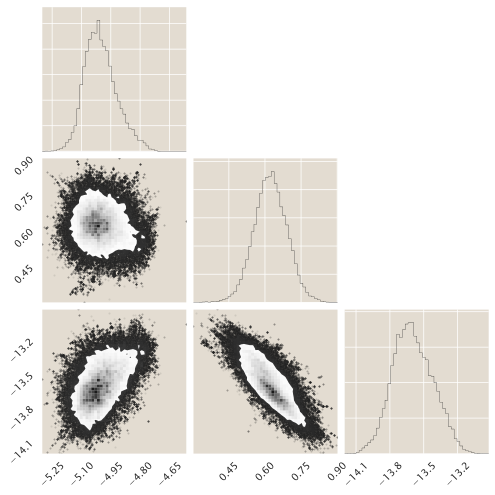

In [46]:
# Load the flat-chain
with open('../../../../data/mcmc/NB_emcee_mutants_dbl_strict.pkl','rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatchain = unpickler.load()

with open('../../../../data/mcmc/NB_emcee_mutants_dbl_lnprob_strict.pkl','rb') as file:
    unpickler = pickle.Unpickler(file)
    gauss_flatlnprobability = unpickler.load()

# # Draw the corner plot
fig = corner.corner(gauss_flatchain[:,[9,19,30]], bins=50, plot_contours=False,
                    rasterized=True)

Now, lets create a Pandas DataFrame out of the MCMC chains.

In [47]:
index = np.concatenate([[mut + '_ka' for mut in unique_var[1]], 
                        [mut + '_ki' for mut in unique_var[1]],
                       ['sigma'],
                      [mut + '_eps' for mut in unique_var[1]]])
df_mcmc = pd.DataFrame(gauss_flatchain, columns=index)

for col in df_mcmc.columns:
    if 'ka' in col:
        df_mcmc[col[:-2]+'Ka'] = np.exp(-df_mcmc[col])
    if 'ki' in col:
        df_mcmc[col[:-2]+'Ki'] = np.exp(-df_mcmc[col])

# redfine the index with the new entries
index = df_mcmc.columns
df_mcmc.head()

,Q21A-F164T_ka,Q21A-Q294K_ka,Q21A-Q294V_ka,Q21M-F164T_ka,Q21M-Q294K_ka,Q21M-Q294V_ka,Y20I-F164T_ka,Y20I-Q294K_ka,Y20I-Q294V_ka,wt_ka,...,Q21A-F164T_Ki,Q21A-Q294K_Ki,Q21A-Q294V_Ki,Q21M-F164T_Ki,Q21M-Q294K_Ki,Q21M-Q294V_Ki,Y20I-F164T_Ki,Y20I-Q294K_Ki,Y20I-Q294V_Ki,wt_Ki
0,-13.292084,-10.835498,-9.060680,-4.607889,-6.890212,-7.260186,-6.397236,-4.391030,-4.180913,-4.850187,...,0.104221,0.023567,0.545120,0.661444,7.249394,12.037821,0.037971,0.816232,0.104094,0.550230
1,-13.292084,-10.835498,-9.060680,-4.607889,-6.890212,-7.260186,-6.397236,-4.391030,-4.180913,-4.850187,...,0.104221,0.023567,0.545120,0.661444,7.249394,12.037821,0.037971,0.816232,0.104094,0.550230
2,-13.237242,-10.823035,-9.028652,-4.621319,-6.870381,-7.254163,-6.391743,-4.418410,-4.192179,-4.852829,...,0.103652,0.022664,0.546661,0.669033,7.175734,12.016480,0.037878,0.835431,0.103936,0.549799
3,-14.673716,-11.662921,-9.529494,-4.360760,-7.559680,-7.142583,-6.467295,-4.111405,-4.087286,-4.802822,...,0.126152,0.024447,0.559842,0.578830,10.120669,12.687941,0.039865,0.656170,0.093422,0.548031
4,-14.065780,-11.202827,-9.251392,-4.632815,-7.214136,-7.178674,-6.419177,-4.357065,-4.189093,-4.843679,...,0.118927,0.022702,0.608584,0.663359,8.033307,11.732474,0.038534,0.827510,0.094531,0.545644


In [48]:
# Generate data frame with mode values for each parameter
max_idx = np.argmax(gauss_flatlnprobability, axis=0)
# Obtain the MAP for each parameter
param_fit = df_mcmc.ix[max_idx, :]
# Convert to data frame with column name mode
param_fit = param_fit.to_frame(name='mode')
# Generate parameter to save the hpd for each parameter
param_hpd = pd.DataFrame(columns=['hpd_min', 'hpd_max'])

# Loop through each parameter computing the 95% hpd
for column in df_mcmc:
    param_hpd = param_hpd.append(pd.Series(np.abs(mwc.hpd(df_mcmc[column], 0.95) - \
                                           param_fit.ix[column, 'mode']),
                               index=['hpd_min', 'hpd_max'], name=column))

# Combine the data frames into a single data frame
param_fit = pd.concat([param_fit, param_hpd], axis=1)
param_fit.round(3)

/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  after removing the cwd from sys.path.
/Users/nathanb/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if sys.path[0] == '':


,mode,hpd_min,hpd_max
Q21A-F164T_ka,-14.021,0.979,6.893
Q21A-Q294K_ka,-7.198,5.199,21.590
Q21A-Q294V_ka,-6.080,7.532,1.170
Q21M-F164T_ka,-5.153,0.490,0.720
Q21M-Q294K_ka,-6.975,2.162,3.512
Q21M-Q294V_ka,-6.950,0.824,1.317
Y20I-F164T_ka,-13.692,1.308,9.528
Y20I-Q294K_ka,-4.146,0.629,1.111
Y20I-Q294V_ka,-5.517,1.978,3.613
wt_ka,-5.045,0.103,0.223


In [49]:
param_fit.to_csv('param_fit_dbl_strict.csv')